## Machine Learning for the 20th century <br> Can a database from 1987 identify a glass cosmetics jar from the 1930s?

Author: Joe Cerniglia <br>
Date: March 18, 2022 <br><br>
This analysis uses a database of glass samples from 1987 developed by ``Ian W. Evett`` and ``Ernest J. Spiehler``. Their paper, first presented at the 1987 conference of the KBS (Knowledge-Based Systems) in Goverment, is: <br>Evett, Ian W. and Spiehler, E. J., "Rule Induction in Forensic Science." http://gpbib.cs.ucl.ac.uk/gp-html/evett_1987_rifs.html<br><br>
The weight percent of eight elemental components and refractive index comprise the features of their database and each sample is represented by a target variable called Type. The types of glass represented in the sample are: Window Float, Window Non-Float, Vehicle Float, Container, Tableware, and Headlamp. There are no Vehicle Non-Float types represented in the data.

I have two glass samples that were independently measured for most of these elements.* The first is a 1930s semi-opaque cosmetic jar with a circular, double-lipped pedestal base. It was recovered from the island of Nikumaroro in 2010 and has been speculated to have possibly belonged to aviation pioneer Amelia Earhart. I will refer to this jar as the ``artifact jar``. The second is a transparent cosmetic jar, purchased on eBay, of unknown manufacture date, in the same size and shape as the first. I will refer to this jar as the ``clear facsimile``. Both jars were manufactured by the Hazel-Atlas Glass Company.

There are two main research questions I wish to answer:<br>
1) What do the correlations between elements for the different types of glass in the 1987 database reveal about late 20th century glassmaking, as compared with early 20th century glassmaking?<br>
2) Using machine learning to train a model on the 1987 database, can that model be used to identify the type (container) of one or both of the older samples unseen by the model?

\* Because silicon was measured in my lab data as 'Matrix,' with no actual number stated, I estimated the silicon for both containers based on the average for containers in the database (72.37). Because K (potassium) was measured at 980 ppm for the clear facsimile, rather than by wt%, I assigned it a value of 50% of the wt% for the artifact jar: .5 * .24 = .12. Because Fe (iron) is at very low wt% levels in the 1987 database, and the levels in my data are listed at very low parts per million (ppm), I assigned to the artifact jar and to the clear facsimile a wt% of Fe of .02 and .01, respectively. These educated guesses were necessary for the machine learning experiment that concludes this notebook.

### Here is a simple report describing the dataset.

In [13]:
from pandas import read_csv
# Make a dictionary of types for later translation.
# When rounding predictions, a type of 0 is sometimes generated.
# The 0 entry in the dictionary allows for this posssibility.
dict = {0: 'WindowF',
  1: 'WindowF',
  2: 'WindowNF',
  3: 'VehicleF',
  4: 'VehicleNF',
  5: 'Container',
  6: 'Tableware',
  7: 'Headlamp'}
# Read in the data into two datasets; one for graphing and the other
# for a machine learning experiment.
filename='glass.data'
names=['ID','Ref_ix','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']

dataset = read_csv(filename, header=None, sep=',',names=names, na_values='.')
dataset_ml = read_csv(
    filename, header=None, sep=',',names=names, na_values='.')

display(dataset_ml.info())
display(dataset_ml.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      214 non-null    int64  
 1   Ref_ix  214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  Type    214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


None

,ID,Ref_ix,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


There are no nulls in the dataset. The column types are all numeric. All 214 samples of the database have been included.

### Here are functions for graphing the count of various glass types in the 1987 database given a range of values for a single element in the periodic table.

In [14]:
def ticks_restrict_to_integer(axis):
    """Restrict the ticks on the given axis to be at least integer,
    that is no half ticks at 1.5 for example.
    """
    from matplotlib.ticker import MultipleLocator
    major_tick_locs = axis.get_majorticklocs()
    if len(major_tick_locs) < 2 or major_tick_locs[1] - major_tick_locs[0] < 1:
        axis.set_major_locator(MultipleLocator(1))    

def numgroups(element,low,high):
    """
    non-fruitful function. Outputs a graph if the number of types of
    glass within the DataFrame is > 1.  Otherwise, the function prints
    a message, for aesthetic reasons.

    parameters:
    element: an element in the periodic table
    low: A minimum value for the measured element, which acts as the 
    minimum value to allow into the dataset sample
    high: A maximum value for the measured element, which acts as the 
    maximum value to allow into the dataset sample

    Preconditions:
    element is a string with value of: 'Mg' or 'Ca' or 'Ba'
    
    Low cannnot be greater than high.
    """
    if low>high:
        print('Low value must be smaller than the high value. Try again.')
        return
    rangedict = {'Ba':['Barium',[.37,.74]],
                 'Mg':['Magnesium',[2.4,4.3]],
                 'Ca':['Calcium',[3.6,8.5]]}
    lowref=rangedict[element][1][0]
    highref=rangedict[element][1][1]
    element_full_name=rangedict[element][0]
    sampl = dataset[(dataset[element] >= low) & (
        dataset[element] <= high)]
    number_groups=sampl['Type'].value_counts().shape[0]
    if number_groups==1:
        print('There is only one sample Type')
        print(sampl['Type'].values[0],'=',sampl.shape[0])
        print('reference: Clear facsimile jar =',lowref,'wt%'
              '\n  1930s Artifact jar=',highref,'wt%')
    else:
        print('reference: Clear facsimile jar =',lowref,'wt%'
              '\n  1930s Artifact jar=',highref,'wt%')
        try:
            sampl['Type'].value_counts().plot(
                kind='bar', figsize=(10, 6), rot=0, cmap='Spectral')
            plt.xlabel("Glass Type", labelpad=14,fontsize=16,rotation=0)
            plt.ylabel("Count of Type", labelpad=70, 
                       fontsize=16,rotation=0)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            ax = plt.subplot()
            ticks_restrict_to_integer(ax.yaxis)
            plt.title(
                "Count of Glass Types in the 1987 database \n with" +
                " a range of of measured values of " + 
                element_full_name + " \n between " + str(low) +
                " and " + str(high) + ' wt%' , y=1.02,fontsize=16)
            plt.show()
        except:
            print('No glass samples are in the range of ' + str(low) +
                " and " + str(high) + ' wt%.')

### What types of glass in the 1987 database are most similar to the older samples in terms of magnesium, barium or calcium content?
Choose from the drop down list below to select one of three elements, magnesium (Mg), barium (Ba) or calcium (Ca), from the periodic table. Each of these elements is an important ingredient in glassmaking, influencing the final appearance of the glass product.<br> Slide the sliders to select a range of values for the element you selected.<br>
Run the graph by pushing the button labeled ``Run Interact``. Once you have run the graph, take a look at the supplied reference values of elemental weight percent from the artifact samples. With the sliders, select a range that closely fits the reference values, and you will receive a precise comparison of how the 1987 database compares with the artifact samples. Set the low slider to 0 and the high slider to maximum to see the distribution of the database as a whole.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import warnings
warnings.filterwarnings('ignore')

dataset.replace({"Type": dict},inplace=True)
ELEMENTS = ['Mg','Ca','Ba']
interact_manual(numgroups, element=ELEMENTS, low=(0, 
        dataset[ELEMENTS].max().max(), 0.01), 
        high=(0, dataset[ELEMENTS].max().max(), 0.01),
                continuous_update=False);


interactive(children=(Dropdown(description='element', options=('Mg', 'Ca', 'Ba'), value='Mg'), FloatSlider(val…

### Analysis
Magnesium:<br>
The clear facsimile jar has 2.4 wt% Mg. Based on the fact that there is only one sample type, tableware, with values between 2.29 and 2.40 wt%, the Mg (were it the only feature) would seem to predict the clear facsimile jar to be in the tableware family, a close cousin to the container family. But there are numerous other windows and even one container directly on either side of these parameters.<br>The artifact jar has 4.3 wt% Mg. This is nearly off-scale high, a value above all others in the database, save one. There is a single float window with 4.49 wt% Mg in the database. Any Mg value above 3.5 wt% is likely to be a window, and not a container.[1]

Calcium:<br>
The clear facsimile jar has 3.6 wt% Ca. This is off-scale low, a value less than all the samples in the database. The next-highest value, 5.43 wt% Ca, is a headlamp.<br>The artifact jar has 8.5 wt% Ca. This is close to the mean in the database, but the mean of containers is higher. Twenty-four (24) windows are associated with this value, as are six (6) headlamps and four (4) vehicle windshields. Containers typically have higher values of Ca, as is shown in the cut of the data in the next section.

Barium:<br>
The ratio of 2:1 for the element Barium in the two glass samples (.74 for the artifact and .37 for the clear facsimile jar) suggests that the glass maker, Hazel-Atlas, used a recipe. This is not uncommon in the glass industry. One window and one headlamp are associated with values of Ba between .25 and .43 wt%. Two headlamps and one window are associated with values of Ba between .69 and .87 wt%.<br><br>Conclusion: We have not yet applied any machine learning to the identification of the unseen samples, but it would appear from the weight percent of some of the key ingredients from these samples that windows, of the float or non-float variety, and, to a lesser extent, headlamps, are strong candidates for how the 1987 database might predict their identity, if machine learning were employed as a predictive tool to do this.

[1] <i>Caddy, Brian, ed.  Forensic Examination of Glass and Paint.  London: Taylor & Francis, 2001, p. 61.<i>

### Turning the question around: If one were to subset only for containers, how would that dataset compare with the reference samples?  Both are containers.

In [16]:
sampcont = dataset[dataset['Type'].isin(['Container'])]
sampcont=sampcont.drop(['ID', 'Type'], axis=1)
print('Container description:')
display(sampcont.describe())
rangedict = {'Ba':['Barium',[.37,.74]],
                 'Mg':['Magnesium',[2.4,4.3]],
                 'Ca':['Calcium',[3.6,8.5]]}
for element in ELEMENTS:
    print()
    print(
        element,': min to max:',sampcont[element].min(),'to'
        ,sampcont[element].max())

    lowref=rangedict[element][1][0]
    highref=rangedict[element][1][1]
    print('reference: Clear facsimile jar =',lowref,'wt%'
              '\n  1930s Artifact jar=',highref,'wt%')

Container description:


,Ref_ix,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,1.518928,12.827692,0.773846,2.033846,72.366154,1.470000,10.123846,0.187692,0.060769
std,0.003345,0.777037,0.999146,0.693920,1.282319,2.138695,2.183791,0.608251,0.155588
min,1.513160,11.030000,0.000000,1.400000,69.890000,0.130000,5.870000,0.000000,0.000000
25%,1.516660,12.730000,0.000000,1.560000,72.180000,0.380000,9.700000,0.000000,0.000000
50%,1.519940,12.970000,0.000000,1.760000,72.690000,0.580000,11.270000,0.000000,0.000000
75%,1.521190,13.270000,1.710000,2.170000,73.390000,0.970000,11.530000,0.000000,0.000000
max,1.523690,14.010000,2.680000,3.500000,73.880000,6.210000,12.500000,2.200000,0.510000



Mg : min to max: 0.0 to 2.68
reference: Clear facsimile jar = 2.4 wt%
  1930s Artifact jar= 4.3 wt%

Ca : min to max: 5.87 to 12.5
reference: Clear facsimile jar = 3.6 wt%
  1930s Artifact jar= 8.5 wt%

Ba : min to max: 0.0 to 2.2
reference: Clear facsimile jar = 0.37 wt%
  1930s Artifact jar= 0.74 wt%


### Generate a custom diverging colormap. Use the drop-down below this code to choose different cuts of the data, based on glass type, and their corresponding correlations interactively.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

TYPES = ['WindowF', 'WindowNF', 'VehicleF', 'Container', 
         'Tableware', 'Headlamp']

def get_dataset(src, glass_type):
    #subset the df into a new df
    df = src[src.Type == glass_type].copy()
    df.drop(['ID'], axis=1,inplace=True)
    return df

def make_heatmap(source, title):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    corr=source.corr()
    # Generate a mask for the lower triangle
    mask = np.tril(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f",
    vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14,rotation=0)
    plt.yticks(fontsize=14,rotation=0)
    plt.gcf().set_size_inches(15, 8)
    return plt

title='WindowF'
def update_heatmap(glass_type):
    plt.title.text = title
    src = get_dataset(dataset, glass_type)
    make_heatmap(src, glass_type + ' glass correlation')

interact(update_heatmap, glass_type=TYPES);


interactive(children=(Dropdown(description='glass_type', options=('WindowF', 'WindowNF', 'VehicleF', 'Containe…

### Analysis
One might expect barium, an ingredient used to increase brilliance, thus increasing refractive index, would be positively correlated with refractive index in these graphs. Barium, however, is frequently absent in the 1987 dataset or present in only trace amounts. It may be that late 20th century glassmaking does not incorporate barium to the same degree that it was incorporated into glass production of the 1930s. See https://tighar.org/Projects/Earhart/Archives/Research/ResearchPapers/freckleintime/Document_05_FrancisFlint1936patent.pdf. Container glass negatively correlates barium with refractive index. Window non-float glass, however, shows a moderate correlation. This makes sense, since this type of glass is often found in churches or for specialized uses in which an aesthetic ambience is desired. See https://en.wikipedia.org/wiki/Crown_glass_(window)#/media/File:AKMuseum5.JPG as an example.

With the exception of headlamps, calcium, probably in the form of calcium oxide, is highly correlated in the 1987 database with refractive index. This may be because of the impurities present in CaO. See https://digitalfire.com/oxide/cao. Therefore, calcium might have been the chosen element to increase brilliance in 1980s glass production, rather than barium. Price pressure might have played a role, but it is not known what the typical rates per ton were for these materials in 1987 or what quantity of CaO, relative to other choices, might be needed to be purchased in the recipe to achieve the desired brilliance of the glass.

As Francis Flint described in his patent (cited above), the use of barium sulfate increased brilliance, but the sulfates needed then to be reduced to prevent small seeds forming in the glass mixture, thus reducing the quality of the glass. Flint recommended zinc, magnesium, aluminum or tin as reducing agents. Sodium and calcium have been recommended in more modern literature of the art [2]. In window non-float glass, aluminum seems to be jointly correlated with barium and refractive index. In tableware, aluminum seems to be jointly correlated with calcium and refractive index.

It would seem good practice to analyze the correlations of each of these glass types separately, as we have done, since obviously the desired qualities of the glass will differ depending on the uses to which the glass will be put, and thus recipes will differ accordingly. The desired refractive index and brilliance of vehicle float glass will be far different than that of container or tableware glass, for example.

The elemental correlations in this 1987 database suggest changing priorities between production techniques of the 1930s and production techniques of the 1980s, toward more utilitarian styles and techniques. One does not require statistics to observe that container glass resembling church windows has all but disappeared, if it ever was very common, giving way to containers in which seeing the contents clearly is the overriding concern. This change will almost certainly affect what specific types of glass that machine learning models can or cannot predict for these unseen samples.

[2] <i>Kaur, Gurbinder. Bioactive Glasses: Potential Biomaterials for Future Therapy. Germany: Springer International Publishing, 2017, p. 107.<i>


### Using machine learning to train a model on the 1987 database, can that model be used to identify the type (container) of one or both of the older samples unseen by the model?

Evaluation of Mean Square Error results of different models
LR: -1.206986 (0.574489)
LASSO: -2.579091 (0.697286)
EN: -2.178775 (0.648028)
KNN: -1.021111 (0.461123)
CART Regressor: -1.560458 (0.975924)
SVR: -4.773633 (1.630235)
KNClass: -1.559150 (0.891198)
RandomForest: -1.048039 (0.798432)


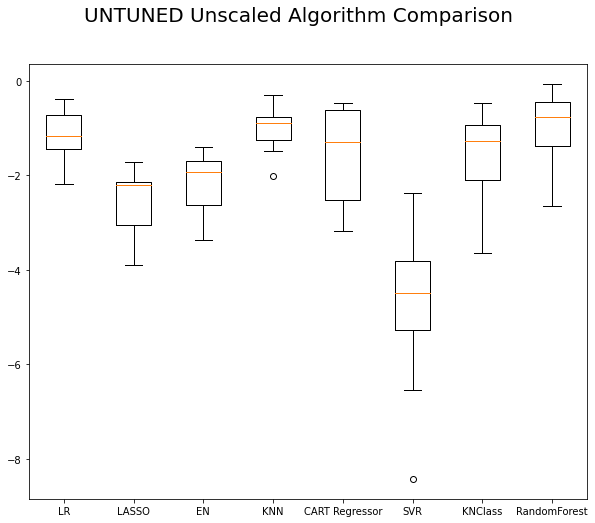



Before SMOTE: Counter({2.0: 61, 1.0: 56, 7.0: 23, 3.0: 14, 5.0: 10, 6.0: 7})
After SMOTE: Counter({1.0: 61, 7.0: 61, 3.0: 61, 2.0: 61, 6.0: 61, 5.0: 61})

Random Forest without SMOTE oversampling
[[12  1  1  0  0  0]
 [ 1 13  0  1  0  0]
 [ 1  1  1  0  0  0]
 [ 0  1  0  3  0  1]
 [ 0  1  0  0  1  0]
 [ 2  0  0  1  0  3]]
Kappa (1=perfect;0=chance;<0=worse than chance): 0.637340
MAD (Mean Absolute Dev): 0.733333
              precision    recall  f1-score   support

         1.0       0.75      0.86      0.80        14
         2.0       0.76      0.87      0.81        15
         3.0       0.50      0.33      0.40         3
         5.0       0.60      0.60      0.60         5
         6.0       1.00      0.50      0.67         2
         7.0       0.75      0.50      0.60         6

    accuracy                           0.73        45
   macro avg       0.73      0.61      0.65        45
weighted avg       0.73      0.73      0.72        45

artifact prediction: WindowNF
The artifa

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

def make_nicer_probability_output(array_to_convert,title):
    """
    Author: Joe Cerniglia
    Date: March 20, 2022
    A function to convert the standard probability scores in Python machine learning libraries
    to a report that supplies the categories from a dictionary and sorts the list of probabilities in
    descending order
    Parameters:
    array_to_convert: an array to convert to a sorted 2d list 
    title: some text to be placed in the title or headings of the report
    Preconditions:
    The array must have the exact number of elements and format needed for the dictionary
    and must be the output of a call to model.predict_proba
    
    returns None. The function itself prints the report.
    """
    prob_list = array_to_convert.tolist()
    # make a 2d list out of the 1d list
    # The 2d list will include a counter variable so that 
    # the dictionary lookup integer key of glass type will 
    # not be dependent on an index for its value,
    # thus allowing a sort and then retrieval of the key
    counter=0
    for type in prob_list[0]:
        prob_list[0][counter]=[counter,type]
        counter+=1
    # We have a 3d list; get back to the 2d list
    prob_list=prob_list[0]
    # Sort in descending order the second column of each row in the 2d list
    # This allows for a descending order of probability and for the
    # predicted type to rise to the top of the list
    prob_list=sorted(prob_list,key=lambda l:l[1], reverse=True)

    counter=0
    for prediction in prob_list:
        if counter==0:
            print('The ' + title + ' has a probability of:')
        print("{:.0%}".format(prediction[1]),'to be a',probdict[prediction[0]])
        counter+=1
    return None


array = dataset_ml.values
X = array[:,1:10]
Y = array[:,10]



validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
    test_size=validation_size, random_state=seed, stratify=Y)

#names=
#  ['Ref_ix','Na',  'Mg',   'Al', 'Si',  'K',  'Ca',  'Ba',  'Fe','Type']
#random headlamp=
    #[1.51602,  14.85, 0.00,  2.38, 73.28, 0.00, 8.76, 0.64, 0.09, 7]
# row equals the 1930s artifact jar.
# row2 equals the clear facsimile jar of unknown date
row=[1.52369,  13.1,  4.3,  .74,   72.37,  .24,  8.5,  .74,  .02]
row2=[1.51316, 11.7,  2.4,  .85,   72.37,  .12,  3.6,  .37,  .01]
row_array=np.array(row).reshape(1,9)
row_array2=np.array(row2).reshape(1,9)
#print('shape:',X_validation.shape)
#print('shape:',row_array.shape)
X_validation=np.append(
X_validation,row_array).reshape(X_validation.shape[0]+1,9)
X_validation=np.append(
X_validation,row_array2).reshape(X_validation.shape[0]+1,9)

#print('shape:',X_validation.shape)
#print('shape:',X_train.shape)

rowval=[5.0]
rowval2=[5.0]
row_array=np.array(rowval).reshape(1,1)
row_array2=np.array(rowval2).reshape(1,1)

Y_validation=np.append(
Y_validation,row_array).reshape(Y_validation.shape[0]+1,1)

Y_validation=np.append(
Y_validation,row_array2).reshape(Y_validation.shape[0]+1,1)


# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'


models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
models.append(('CART Regressor', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('KNClass',KNeighborsClassifier(n_neighbors=5)))
models.append(('RandomForest',RandomForestClassifier(
n_estimators=100, max_features=9,class_weight='balanced')))
# evaluate each model in turn
results = []
names = []
print('Evaluation of Mean Square Error results of different models')
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(
  model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

 # Compare Algorithms
fig = plt.figure()
fig.suptitle('UNTUNED Unscaled Algorithm Comparison',fontsize=20)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.gcf().set_size_inches(10, 8)
plt.show()


probdict = {0: 'WindowF',
  1: 'WindowNF',
  2: 'VehicleF',
  3: 'Container',
  4: 'Tableware',
  5: 'Headlamp'}

print()
print()
counter=Counter(Y_train)
print('Before SMOTE:',counter)

oversample = SMOTE(random_state=42,k_neighbors=5)
X_trainsm, Y_trainsm = oversample.fit_resample(X_train, Y_train)
counter=Counter(Y_trainsm)
print('After SMOTE:',counter)

modelnoSMOTE=make_pipeline(
StandardScaler(),RandomForestClassifier(
n_estimators=100,max_features=9,class_weight='balanced'))


modelwithSMOTE=make_pipeline(
StandardScaler(),SMOTE(
random_state=42, k_neighbors=5),RandomForestClassifier(
n_estimators=100,max_features=9,class_weight='balanced'))


modelnoSMOTE.fit(X_train, Y_train)

print()
print('Random Forest without SMOTE oversampling')
predictions = modelnoSMOTE.predict(X_validation)
ytrue=5
predictions=np.round(predictions, 0)

print(confusion_matrix(Y_validation, predictions))
kappa=cohen_kappa_score(Y_validation, np.round(predictions,0))
MAD = mean_absolute_error(Y_validation, predictions)
print('Kappa (1=perfect;0=chance;<0=worse than chance): %f' % kappa)
print('MAD (Mean Absolute Dev): %f' % MAD)
print(classification_report(Y_validation, predictions, zero_division=1))
yhat = modelnoSMOTE.predict([row])
yhat2 = modelnoSMOTE.predict([row2])
yhat_probability = modelnoSMOTE.predict_proba([row])
yhat2_probability = modelnoSMOTE.predict_proba([row2])

print('artifact prediction:',dict[np.round(yhat[0])])
make_nicer_probability_output(yhat_probability,'artifact')
print()
print('clear facsimile prediction:',dict[np.round(yhat2[0])])
make_nicer_probability_output(yhat2_probability,'clear facsimile')


modelwithSMOTE.fit(X_train, Y_train)

print()
print('Random Forest with SMOTE oversampling')
predictions = modelwithSMOTE.predict(X_validation)
ytrue=5
predictions=np.round(predictions, 0)

print(confusion_matrix(Y_validation, predictions))
kappa=cohen_kappa_score(Y_validation, np.round(predictions,0))
MAD = mean_absolute_error(Y_validation, predictions)
print('Kappa (1=perfect;0=chance;<0=worse than chance): %f' % kappa)
print('MAD (Mean Absolute Dev): %f' % MAD)
print(classification_report(Y_validation, predictions, zero_division=1))
yhat = modelwithSMOTE.predict([row])
yhat2 = modelwithSMOTE.predict([row2])
yhat_probability = modelwithSMOTE.predict_proba([row])
yhat2_probability = modelwithSMOTE.predict_proba([row2])
    

print('artifact prediction:',dict[np.round(yhat[0])])
make_nicer_probability_output(yhat_probability,'artifact')
print()
print('clear facsimile prediction:',dict[np.round(yhat2[0])])
make_nicer_probability_output(yhat2_probability,'clear facsimile')

### Analysis Procedure
The following sequence of operations was performed:<br>
1) Create two arrays. The first contains the database features, all of the predictive columns of the original dataset. The second contains the target column, Type.<br>
2) Create a train-test, stratified split so that the model can be trained on 80% of the data and validated on a subsample of 20%.<br>
3) Add the 2 exogenous glass sample jars to the validation (unseen) data, both for features (X) and for target (Y).<br>
4) Test a set of regression and classification models on the training dataset and report the MSE (mean squared error) results for each one, as well as the standard deviation of the MSE.<br>
5) Plot the preliminary effectiveness of each model on a box plot.<br>
6) Select the model most likely to succeed. In this case, Random Forest Classifier was selected. Use the standard scaler to make the scale of the features more uniform with one another, and a class weight of 'balanced' to minimize the imbalance in the glass type categories.<br> 
7) Fit the model to the dataset.<br>
8) Print a report on the performance of the model.<br>
9) Print a report on the predicted result for both of the two unseen jars and the probability of the prediction for each glass type.<br>

### Findings
One of the most interesting findings was that when the SMOTE oversampling algorithm was applied to the data pipeline prior to applying the model, the resolving power of the model increased to the point that it was consistently able to identify the clear facsimile jar correctly as a container. Without the SMOTE oversampling algorithm applied, the model predicted the clear facsimile jar to be a headlamp. The prediction of container scored a distant third or fourth place.

The non-SMOTE model predicted the 1930s artifact jar to be a window, usually of the float variety*. This is very close to the prediction made by the model when SMOTE was used. Following application of SMOTE oversampling, the model predicted the artifact jar to be a non-float window.

These machine learning model predictions would seem to indicate that the clear facsimile jar of unknown date can be correctly identified through prudent enhancement of the model with oversampling techniques. These techniques, however, are ineffective in increasing the ability of the model to predict the 1930s artifact jar to be what it is, a container.

Using a well-tuned model, the fact that a non-float window, of a type often typically seen in churches, could be predicted for the 1930s artifact jar demonstrates that this database of late 20th century glassware lacks enough relevant case examples that would allow it to predict this artifact correctly.

### Conclusions
But could these case examples be found? Our machine learning model can correctly characterize the clear facsimile, a jar of the same size and shape as the artifact, and possibly from the same era. The model cannot correctly characterize the semi-opaque 1930s artifact jar. One might suppose that the 1930s artifact jar has a rare and original recipe that, in the absence of any information other than the data nourishing the model, is not readily identifiable as to the glass type, even with the powerful machine learning tools, such as random forests, available to us in 2022. This fact is further confirmation of the artifact jar's originality, perhaps even in its own time.

\* Because the model is stochastic in nature, results will not be exactly the same each time.